In [124]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import tensorflow as tf
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [125]:
BATCH_SIZE=32
IMAGE_HEIGHT=256
IMAGE_WIDTH=256
CHANNELS=3
EPOCHS=25
data_dir = r"../data/PlantVillage/"


In [126]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [127]:
class_names=dataset.class_names
class_names

['Early_blight', 'Healthy', 'Late_blight']

(32, 256, 256, 3)
[1 2 0 0 2 2 0 2 2 0 2 2 2 1 2 0 2 0 2 0 2 0 2 0 2 2 0 2 2 1 0 2]


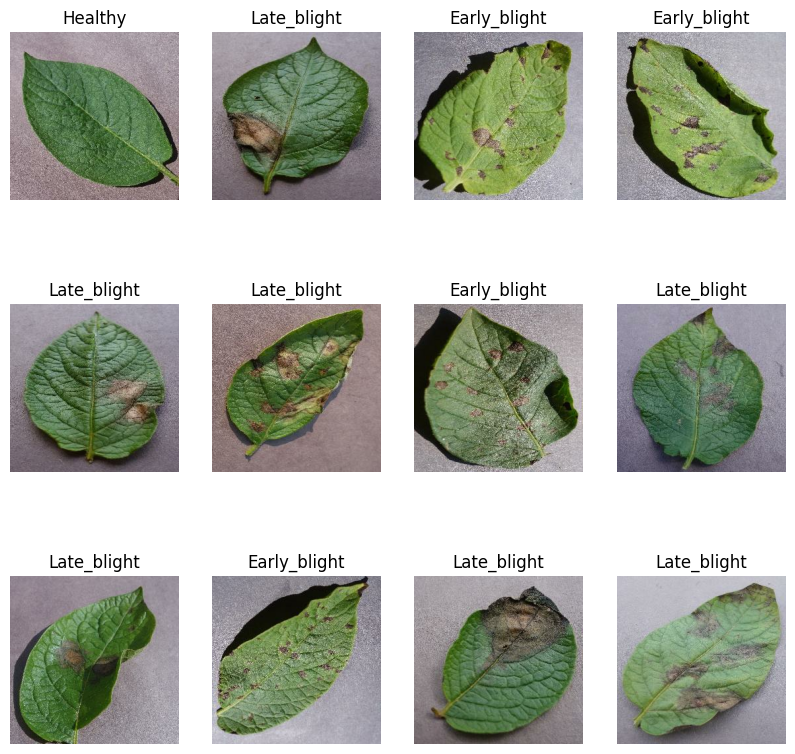

In [128]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):#12 images
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))#imshow pass 2d array ,i tensor to numpy ,float to uint8
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [129]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split+val_split+test_split)==1
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)# seed same samples
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)#test dataset
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [130]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

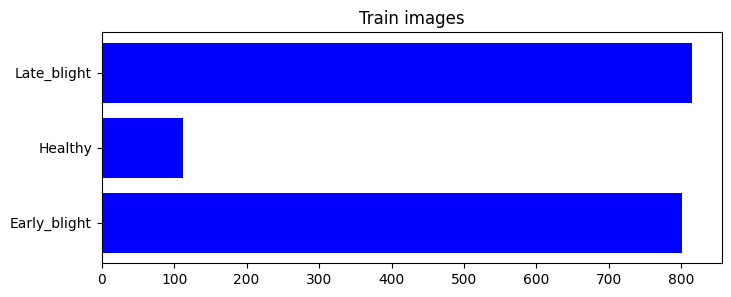

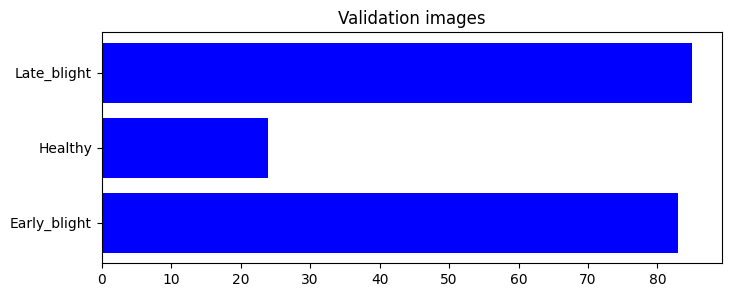

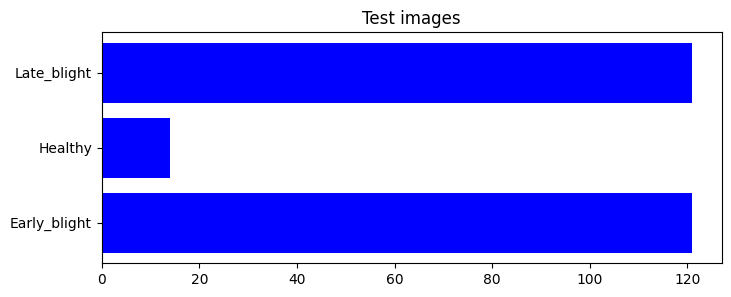

In [131]:
def plot_distribution(y, title):
    a = Counter(y)
    y = ['Early_blight', 'Healthy', 'Late_blight']
    
    x = [a[i] for i in range(3)]
    plt.figure(figsize=(8, 3))
    plt.barh(y, x, color='blue')
    plt.title(title)
    return plt.show()

y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)
y_test = np.concatenate([y for x, y in test_ds], axis=0)

plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title = "Validation images")
plot_distribution(y_test, title = "Test images")

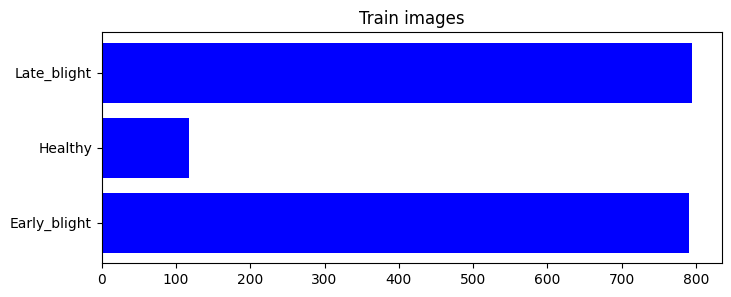

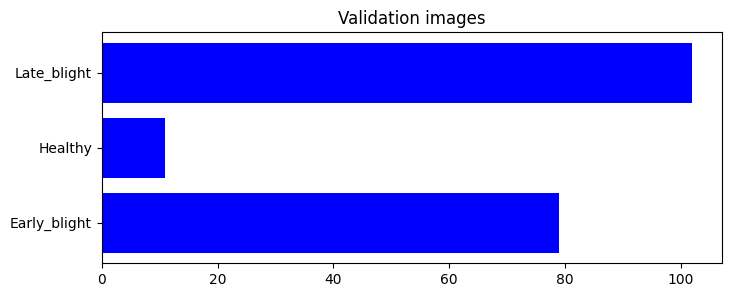

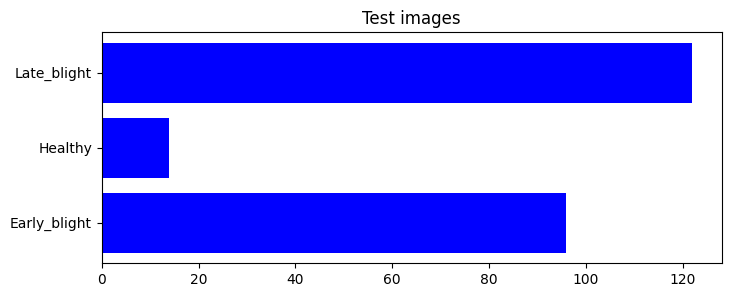

In [132]:
# Target distribution

y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_val = np.concatenate([y for x, y in val_ds], axis=0)
y_test = np.concatenate([y for x, y in test_ds], axis=0)
plot_distribution(y_train, title="Train images")
plot_distribution(y_val, title = "Validation images")
plot_distribution(y_test, title = "Test images")

In [133]:
#training and testing dataset
#validation for each epochs fro accuracy
# 80%->training 10% test=> 10%->validation 10%->testing

In [134]:
#cache,shuffle,fetch


In [135]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [136]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)# cache->disk to memory faster access laoding
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#images in numpy array

In [137]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[173. 162. 170.]
  [205. 194. 202.]
  [211. 200. 208.]
  ...
  [185. 172. 181.]
  [200. 187. 196.]
  [185. 172. 181.]]

 [[183. 172. 180.]
  [197. 186. 194.]
  [165. 154. 162.]
  ...
  [188. 175. 184.]
  [162. 149. 158.]
  [203. 190. 199.]]

 [[209. 198. 206.]
  [202. 191. 199.]
  [207. 196. 204.]
  ...
  [177. 164. 173.]
  [140. 127. 136.]
  [199. 186. 195.]]

 ...

 [[189. 167. 170.]
  [130. 108. 111.]
  [178. 156. 159.]
  ...
  [188. 162. 171.]
  [198. 172. 181.]
  [168. 142. 151.]]

 [[127. 105. 108.]
  [156. 134. 137.]
  [151. 129. 132.]
  ...
  [185. 159. 168.]
  [187. 161. 170.]
  [176. 150. 159.]]

 [[137. 115. 118.]
  [156. 134. 137.]
  [181. 159. 162.]
  ...
  [208. 182. 191.]
  [176. 150. 159.]
  [142. 116. 125.]]]


In [138]:
#normalise divide by 255
#create keras layer to normalise


In [139]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_HEIGHT,IMAGE_WIDTH),# if image is not 256x256 in actual production
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [140]:
#for random flip random rotation

In [141]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),# if image is not 256x256 in actual production
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
]) 

In [142]:
#model

In [143]:
input_shape=(BATCH_SIZE,IMAGE_HEIGHT,IMAGE_WIDTH,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [144]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_19 (MaxPoolin  (32, 62, 62, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (32, 60, 60, 32)        

In [145]:
#compile model


In [146]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
)

In [147]:
history=model.fit(
  train_ds,
  batch_size=BATCH_SIZE,
  validation_data=val_ds,
  verbose=1,#detail information
  epochs=EPOCHS
)

Epoch 1/25
54/54 [==============================] - 92s 2s/step - loss: 0.9182 - accuracy: 0.4583 - val_loss: 0.8412 - val_accuracy: 0.4271
Epoch 2/25
54/54 [==============================] - 87s 2s/step - loss: 0.8150 - accuracy: 0.5862 - val_loss: 0.6827 - val_accuracy: 0.6927
Epoch 3/25
54/54 [==============================] - 87s 2s/step - loss: 0.5990 - accuracy: 0.7344 - val_loss: 0.6145 - val_accuracy: 0.7188
Epoch 4/25
54/54 [==============================] - 85s 2s/step - loss: 0.4640 - accuracy: 0.8096 - val_loss: 0.4003 - val_accuracy: 0.8594
Epoch 5/25
54/54 [==============================] - 85s 2s/step - loss: 0.3431 - accuracy: 0.8576 - val_loss: 0.2741 - val_accuracy: 0.8906
Epoch 6/25
54/54 [==============================] - 86s 2s/step - loss: 0.2548 - accuracy: 0.9080 - val_loss: 0.3941 - val_accuracy: 0.8698
Epoch 7/25
54/54 [==============================] - 87s 2s/step - loss: 0.2128 - accuracy: 0.9167 - val_loss: 0.2478 - val_accuracy: 0.9167
Epoch 8/25
54/54 [==

In [148]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 5s 379ms/step - loss: 0.0551 - accuracy: 0.9883


In [149]:
scores   

[0.05508844554424286, 0.98828125]

In [150]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [151]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


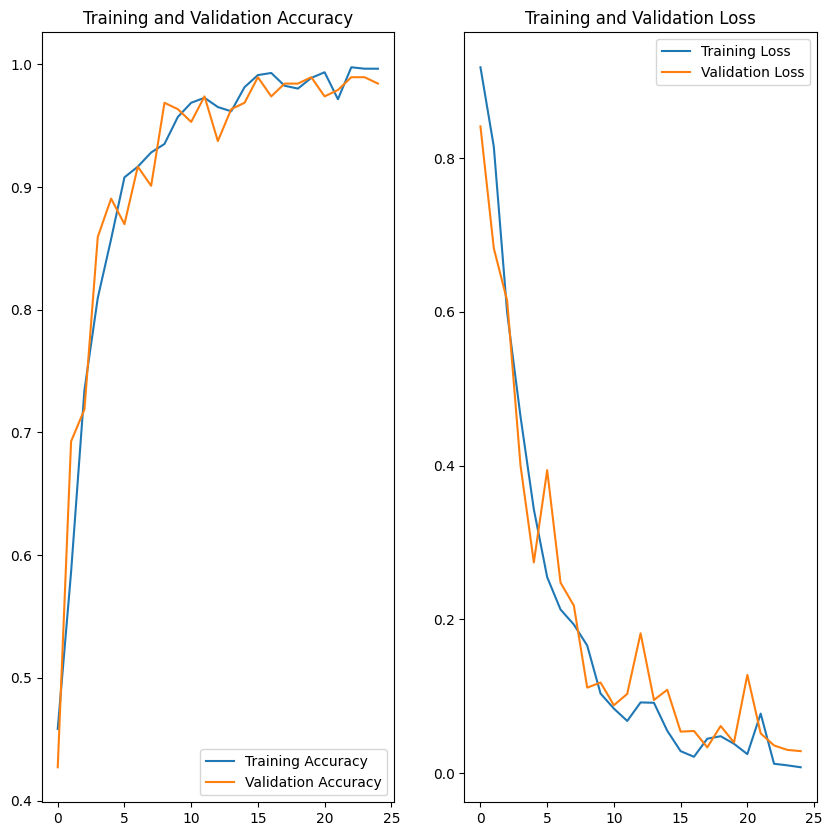

In [152]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Actual Labels: Late_blight
1/1 [==============================] - 1s 521ms/step
Predicted Label: Late_blight


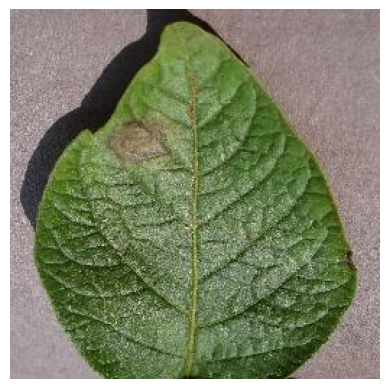

In [153]:
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    plt.imshow(first_image)
    print("Actual Labels:",class_names[labels_batch[0].numpy()])
    batch_prediction=model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

In [154]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) #create a batch
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 35ms/step


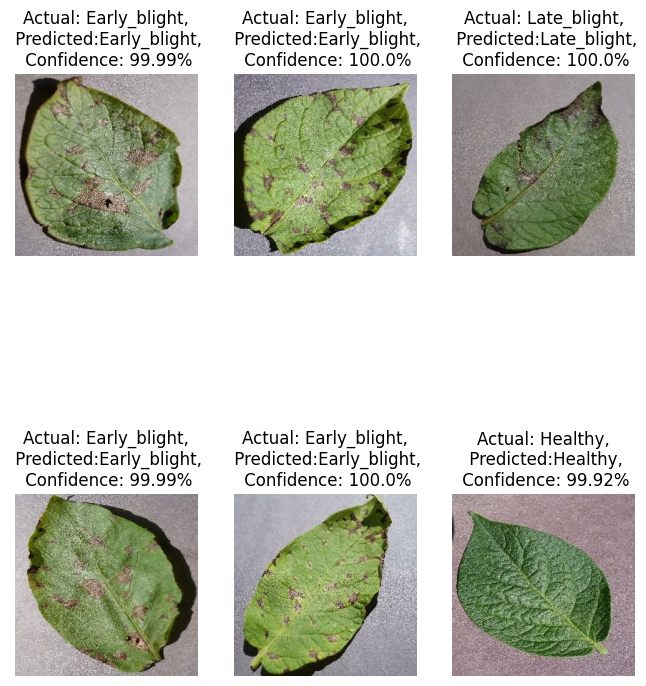

In [155]:
plt.figure(figsize=(8,10))
for images,labels in test_ds.take(1):
    for i in range(6):
        ax=plt.subplot(2,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted:{predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")


In [156]:
loss, acc = model.evaluate(val_ds, batch_size=BATCH_SIZE)
print("validation accuracy :", round(acc, 2))
print("validation loss :", round(loss,2))

6/6 [==============================] - 2s 383ms/step - loss: 0.0285 - accuracy: 0.9844
validation accuracy : 0.98
validation loss : 0.03


In [157]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 492ms/step


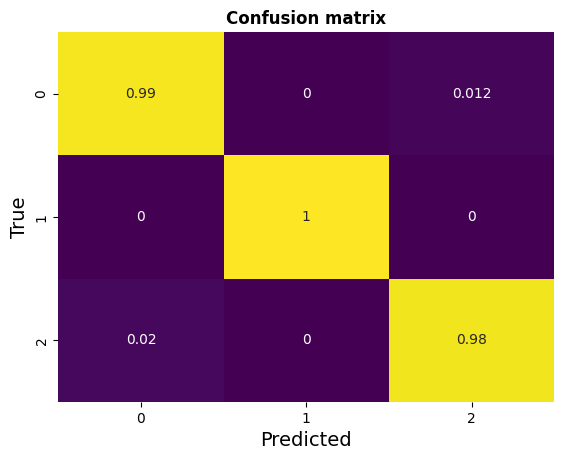

In [158]:
cm = confusion_matrix(correct_labels, predicted_labels, normalize='true')
sns.heatmap(cm, annot=True, cmap='viridis', cbar=None)
plt.title("Confusion matrix", fontweight='bold')
plt.ylabel("True", fontsize=14)
plt.xlabel("Predicted", fontsize=14)
plt.show()

In [159]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        82
           1       1.00      1.00      1.00        10
           2       0.99      0.98      0.98       100

    accuracy                           0.98       192
   macro avg       0.99      0.99      0.99       192
weighted avg       0.98      0.98      0.98       192



In [160]:
model.save("../application/static/models/model_v1.h5")

In [161]:
def prediction(img):
    class_names = ['Early_blight', 'Healthy', 'Late_blight']

    my_image = load_img(img, target_size=(IMAGE_HEIGHT,IMAGE_WIDTH))
    my_image = img_to_array(my_image)
    my_image = np.expand_dims(my_image, 0)

    out = np.round(model.predict(my_image)[0], 2)
    fig = plt.figure(figsize=(7, 4))
    plt.barh(class_names, out, color='lightgray',edgecolor='red', linewidth=1, height=0.5)

    for index, value in enumerate(out):
        plt.text(value/2 + 0.1, index, f"{100*value:.2f}%", fontweight='bold')

    plt.xticks([])
    plt.yticks([0, 1, 2],labels=class_names, fontweight='bold', fontsize=14)
    fig.savefig('pred_img.png', bbox_inches='tight')
    return plt.show()

1/1 [==============================] - 0s 64ms/step


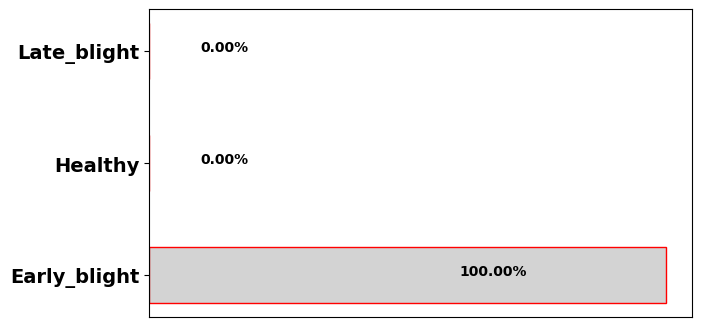

In [162]:
img = '../data/PlantVillage/Early_blight/0a8a68ee-f587-4dea-beec-79d02e7d3fa4___RS_Early.B 8461.JPG'
prediction(img)

1/1 [==============================] - 0s 42ms/step


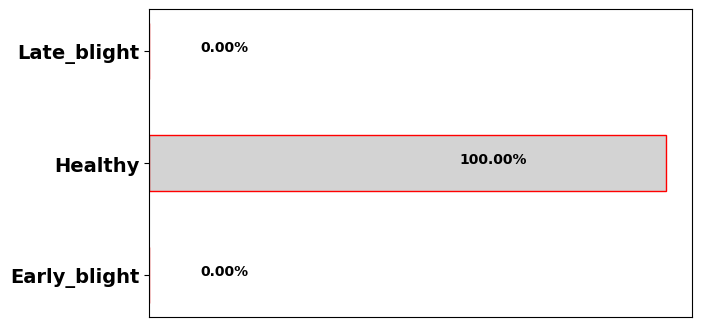

In [163]:
img = '../data/PlantVillage/Healthy/0b3e5032-8ae8-49ac-8157-a1cac3df01dd___RS_HL 1817.JPG'
prediction(img)

1/1 [==============================] - 0s 47ms/step


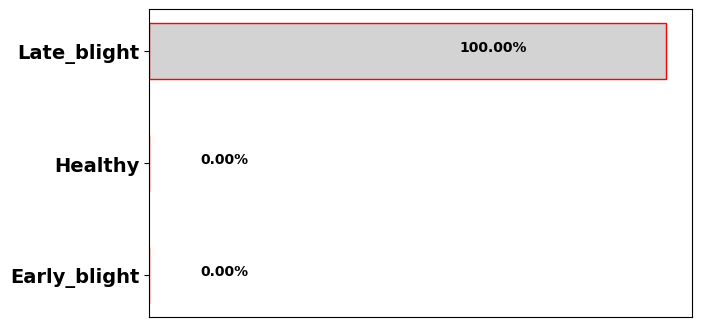

In [164]:
img = '../data/PlantVillage/Late_blight/0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG'
prediction(img)